## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [2]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sat Mar 30 17:40:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    N/A /  N/A |     69MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
from numba import cuda
import itertools
import matplotlib.pyplot as plt
plt.style.use('ggplot')

cuda.select_device(0)
cuda.close()
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
def build_mlp(regularizer, reg_ratio, input_shape, output_units=y_train.shape[-1], num_neurons=[256, 128, 64, 32]):
    
    input_layer = keras.layers.Input(input_shape)
    
    switcher = {'L1': l1(reg_ratio), 'L2': l2(reg_ratio), 'L1_L2': l1_l2(reg_ratio)}
    kernel_regularizer = switcher.get(regularizer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [13]:
colors = ['#9a0eea', '#15b01a', '#0343df', '#ff81c0', '#653700', 
          '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14',
          '#06c2ac', '#00035b', '#d1b26f', '#677a04', '#ae7181', '#ffb07c']

def plotting(results, color_bar=colors):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    for i, cond in enumerate(results.keys()):

        epochs = range(1, len(results[cond]['train_loss']) + 1)

        ax1.plot(epochs, results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
        ax1.plot(epochs, results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
        
        ax2.plot(epochs, results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
        ax2.plot(epochs, results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
        
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_title('Loss', fontsize=25)
    ax1.legend()
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_title('Accuracy', fontsize=25)
    ax2.legend()
    plt.show()

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
OPTIMIZER = 'sgd'
EPOCHS = 50
BATCH_SIZE = 256

REGULARIZER = ['L1', 'L1_L2']
REG_EXP = [1e-2, 1e-4, 1e-8]

In [10]:
def model_fitting(regularizer, reg_ratio, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:]):
    
    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    
    model = build_mlp(regularizer=regularizer, reg_ratio=reg_ratio, input_shape=input_shape)
    model.summary()
    
    switcher = {'sgd': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'rmsp': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'adag': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}
    optimizer = switcher.get(optimizer)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=False,
                        verbose=2)
    
    sess.close()

    return history

In [11]:
results = {}

for rzr, ratio in itertools.product(REGULARIZER, REG_EXP):
    
    history = model_fitting(regularizer=rzr, reg_ratio=ratio)
    
    name_tag = f'{rzr}, ratio={ratio}'
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 256)               786688    
_________________________________________________________________
hidden_layers2 (Dense)       (None, 128)               32896     
_________________________________________________________________
hidden_layers3 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_layers4 (Dense)       (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 830,250
Trainable params: 830,250
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 21/50
 - 5s - loss: 2.7134 - acc: 0.5390 - val_loss: 2.7936 - val_acc: 0.5027
Epoch 22/50
 - 5s - loss: 2.6769 - acc: 0.5434 - val_loss: 2.7655 - val_acc: 0.5038
Epoch 23/50
 - 5s - loss: 2.6400 - acc: 0.5476 - val_loss: 2.7385 - val_acc: 0.5075
Epoch 24/50
 - 5s - loss: 2.6048 - acc: 0.5517 - val_loss: 2.7137 - val_acc: 0.5078
Epoch 25/50
 - 5s - loss: 2.5712 - acc: 0.5557 - val_loss: 2.6883 - val_acc: 0.5074
Epoch 26/50
 - 5s - loss: 2.5374 - acc: 0.5597 - val_loss: 2.6674 - val_acc: 0.5070
Epoch 27/50
 - 5s - loss: 2.5054 - acc: 0.5629 - val_loss: 2.6479 - val_acc: 0.5059
Epoch 28/50
 - 5s - loss: 2.4736 - acc: 0.5663 - val_loss: 2.6253 - val_acc: 0.5080
Epoch 29/50
 - 5s - loss: 2.4423 - acc: 0.5698 - val_loss: 2.6005 - val_acc: 0.5093
Epoch 30/50
 - 5s - loss: 2.4109 - acc: 0.5733 - val_loss: 2.5795 - val_acc: 0.5124
Epoch 31/50
 - 5s - loss: 2.3795 - acc: 0.5772 - val_loss: 2.5604 - val_acc: 0.5106
Epoch 32/50
 - 5s - loss: 2.3494 - acc: 0.5806 - val_loss: 2.5307 - val_acc:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 4s - loss: 101.8777 - acc: 0.1916 - val_loss: 22.4359 - val_acc: 0.1951
Epoch 2/50
 - 3s - loss: 13.1041 - acc: 0.1047 - val_loss: 7.6820 - val_acc: 0.1000
Epoch 3/50
 - 3s - loss: 4.9803 - acc: 0.1000 - val_loss: 3.3349 - val_acc: 0.1000
Epoch 4/50
 - 3s - loss: 2.8301 - acc: 0.0985 - val_loss: 2.5316 - val_acc: 0.1000
Epoch 5/50
 - 3s - loss: 2.4418 - acc: 0.0979 - val_loss: 2.3849 - val_acc: 0.1000
Epoch 6/50
 - 3s - loss: 2.3796 - acc: 0.0971 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 7/50
 - 3s - loss: 2.3789 - acc: 0.0962 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 8/50
 - 3s - loss: 2.3789 - acc: 0.0967 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 9/50
 - 3s - loss: 2.3789 - acc: 0.0966 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 10/50
 - 3s - loss: 2.3789 - acc: 0.0972 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 11/50
 - 3s - loss: 2.3788 - acc: 0.0970 - val_loss: 2.3787 - val_acc: 0.1000
Epoch 12/50
 - 3s - loss: 2.378

 - 3s - loss: 1.8663 - acc: 0.4525 - val_loss: 1.8716 - val_acc: 0.4534
Epoch 35/50
 - 3s - loss: 1.8590 - acc: 0.4541 - val_loss: 1.8662 - val_acc: 0.4554
Epoch 36/50
 - 3s - loss: 1.8525 - acc: 0.4559 - val_loss: 1.8592 - val_acc: 0.4583
Epoch 37/50
 - 3s - loss: 1.8463 - acc: 0.4568 - val_loss: 1.8546 - val_acc: 0.4596
Epoch 38/50
 - 3s - loss: 1.8409 - acc: 0.4584 - val_loss: 1.8499 - val_acc: 0.4603
Epoch 39/50
 - 3s - loss: 1.8369 - acc: 0.4599 - val_loss: 1.8469 - val_acc: 0.4626
Epoch 40/50
 - 3s - loss: 1.8319 - acc: 0.4610 - val_loss: 1.8421 - val_acc: 0.4627
Epoch 41/50
 - 3s - loss: 1.8280 - acc: 0.4611 - val_loss: 1.8382 - val_acc: 0.4655
Epoch 42/50
 - 3s - loss: 1.8241 - acc: 0.4627 - val_loss: 1.8388 - val_acc: 0.4646
Epoch 43/50
 - 3s - loss: 1.8196 - acc: 0.4643 - val_loss: 1.8360 - val_acc: 0.4662
Epoch 44/50
 - 3s - loss: 1.8167 - acc: 0.4645 - val_loss: 1.8324 - val_acc: 0.4673
Epoch 45/50
 - 3s - loss: 1.8139 - acc: 0.4658 - val_loss: 1.8300 - val_acc: 0.4692
Epoc

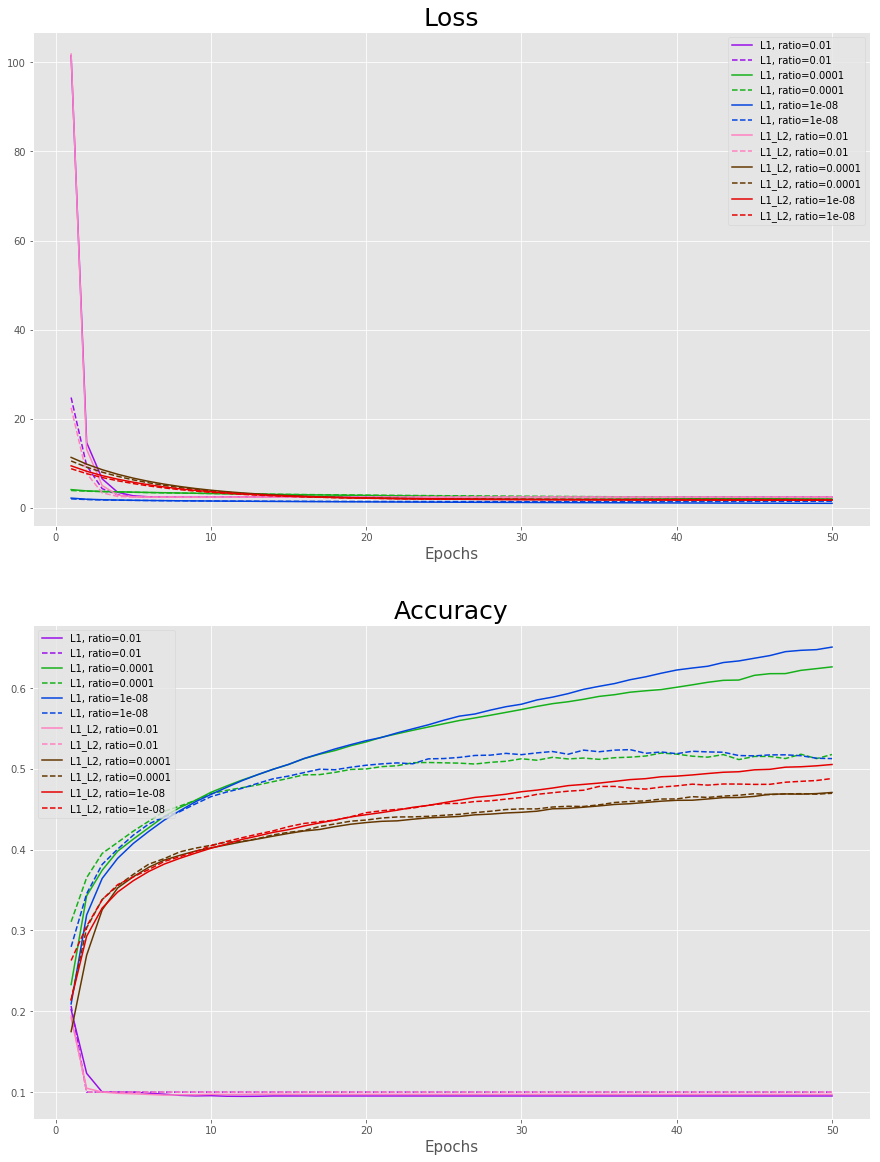

In [14]:
plotting(results)